In [3]:
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

import lsdb

In [21]:
#Load ZTF, Gaia, and ZTF sources hipscats
gaia = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/gaia_dr3/gaia")

ztf = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

#sources load takes a minute, since it creates a healpix alignment on load
ztf_sources = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source",
                               columns=['index', 'ps1_objid',
                                       'ra', 'dec', 
                                       'catflags', 
                                       'fieldID', 
                                       'mjd', 'band', 'mag', 'magerr', 'Npix'])

In [26]:
gs1 = gaia.query("parallax > 0 and parallax_over_error > 5 and \
    teff_gspphot > 5380 and teff_gspphot< 7220 and logg_gspphot > 4.5 \
    and logg_gspphot < 4.72 and classprob_dsc_combmod_star > 0.5")

In [29]:
z1 = ztf.query("nobs_g > 100 and nobs_r > 100")

In [39]:
total = z1.crossmatch(gs1, require_right_margin=False)

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


In [41]:
%%time
total._ddf.shape[0].compute()

CPU times: user 2h 32min 21s, sys: 6h 28min 24s, total: 9h 46s
Wall time: 37min 16s


5368975

In [46]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
from healpy.newvisufunc import projview

def cat2hpx(lon, lat, nside, radec=True):
    """
    Convert a catalogue to a HEALPix map of number counts per resolution
    element.

    Parameters
    ----------
    lon, lat : (ndarray, ndarray)
        Coordinates of the sources in degree. If radec=True, assume input is in the icrs
        coordinate system. Otherwise assume input is glon, glat

    nside : int
        HEALPix nside of the target map

    radec : bool
        Switch between R.A./Dec and glon/glat as input coordinate system.

    Return
    ------
    hpx_map : ndarray
        HEALPix map of the catalogue number counts in Galactic coordinates
    """
    npix = hp.nside2npix(nside)
    
    if radec:
        eq = SkyCoord(lon, lat, 'icrs', unit='deg')
        l, b = eq.galactic.l.value, eq.galactic.b.value
    else:
        l, b = lon, lat

    # conver to theta, phi
    theta = np.radians(90. - b)
    phi = np.radians(l)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    idx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts
    
    return hpx_map


In [47]:
Sky = SkyCoord(ra=xm_table.ra_gaia.values*u.deg, 
              dec=xm_table.dec_gaia.values*u.deg)

In [48]:
# convert coordinates to Galactic frame (l,b)
sky_gal = Sky.galactic

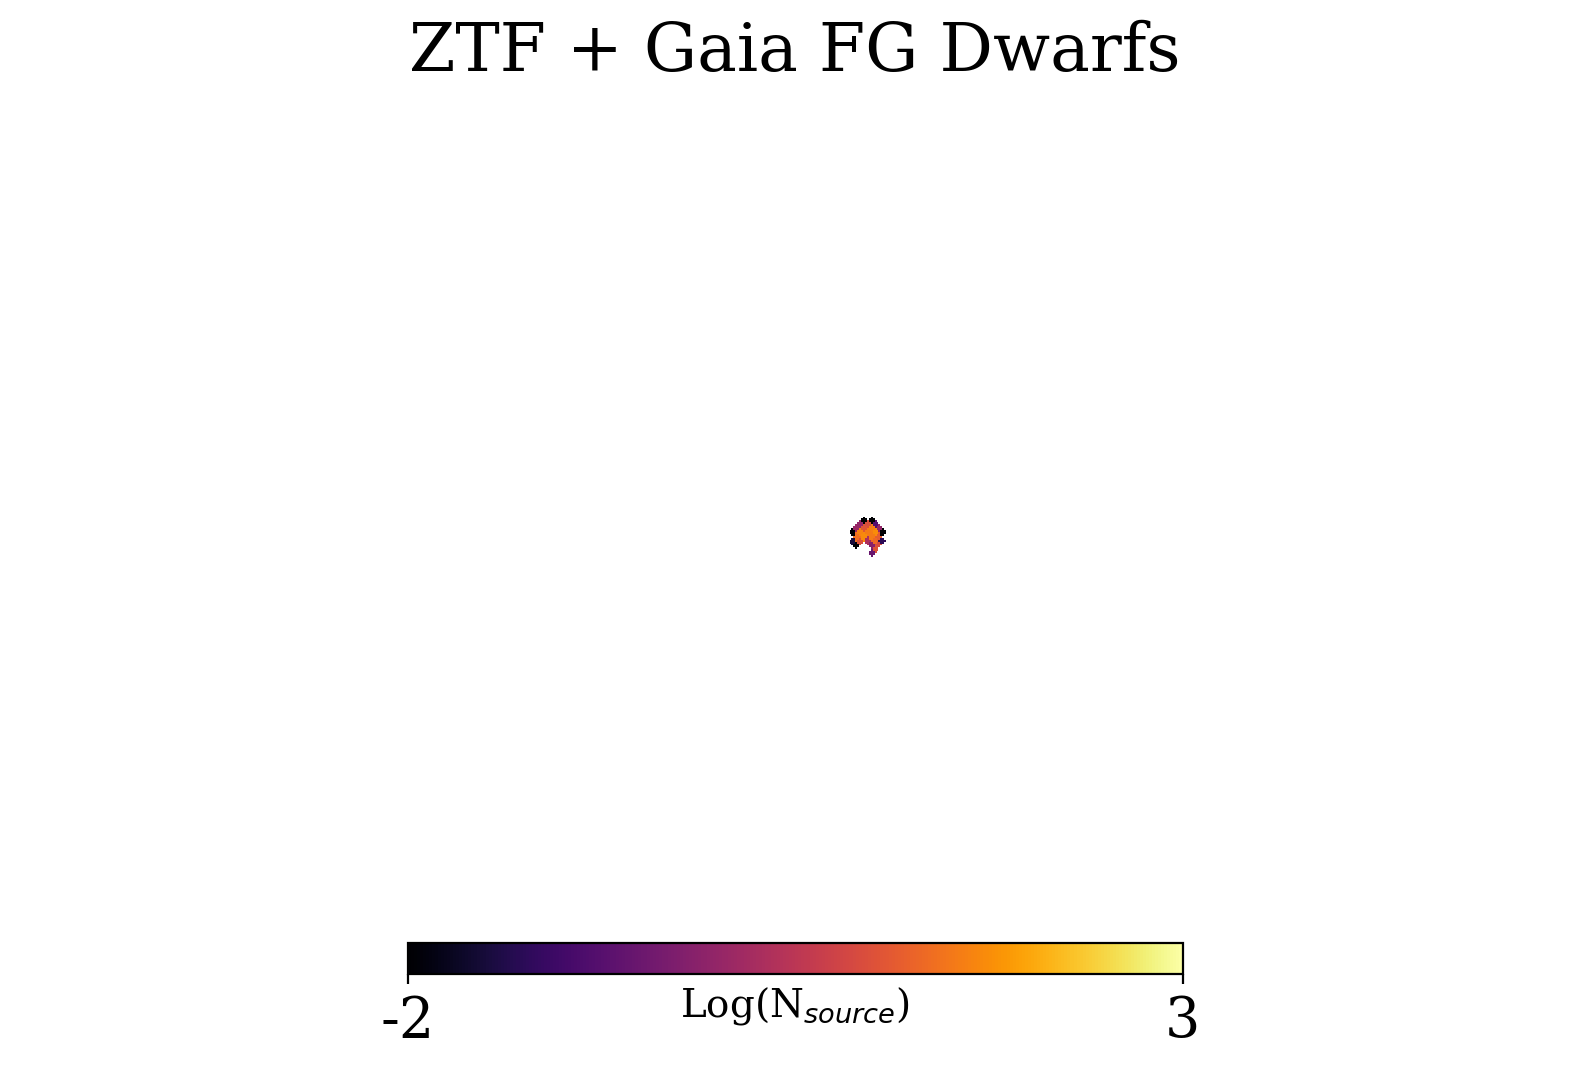

In [49]:
# Create Healpy projection 
hpx_map = cat2hpx(sky_gal.l.value-180,
                  sky_gal.b.value, 
                  nside=50, radec=False)

plt.figure(figsize=(10,10))
plt.grid(True, color='k', lw=22)
hp.mollview(np.log(hpx_map), cmap='inferno', hold=True,min=-2, max=3,
                   flip='astro', remove_dip=False,
                   remove_mono=True, 
                  title='ZTF + Gaia FG Dwarfs', 
           unit='Log(N$_{source}$)')

In [50]:
# hipscat xm_table
table_hips = lsdb.from_dataframe(
    xm_table, 
    lowest_order=5, 
    highest_order=8, 
    set_hipscat_index=False, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1e10
)

# load lazy
source_tbl_final = table_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid"
)

In [51]:
pth = '/astro/users/atzanida/datalrg'

In [52]:
type(source_tbl_final)

lsdb.catalog.catalog.Catalog

In [54]:
%%time
source_tbl_final.compute()

CPU times: user 8.44 s, sys: 3.98 s, total: 12.4 s
Wall time: 40.5 s


,ra_gaia,dec_gaia,bp_rp_gaia,parallax_gaia,parallax_over_error_gaia,phot_g_mean_mag_gaia,pmra_gaia,pmdec_gaia,classprob_dsc_combmod_star_gaia,logg_gspphot_gaia,...,ps1_objid,ra,dec,catflags,fieldID,mjd,band,mag,magerr,Npix
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
345157491895566336,65.341598,32.741695,1.212202,0.349576,5.522325,16.466784,4.725263,-1.427001,0.999991,4.6256,...,147290653415800628,65.341596,32.741721,0,1653,58765.45763,g,17.129642,0.017830,4904
345157491895566336,65.341598,32.741695,1.212202,0.349576,5.522325,16.466784,4.725263,-1.427001,0.999991,4.6256,...,147290653415800628,65.341596,32.741721,0,1653,58765.45808,g,17.122194,0.017781,4904
345157491895566336,65.341598,32.741695,1.212202,0.349576,5.522325,16.466784,4.725263,-1.427001,0.999991,4.6256,...,147290653415800628,65.341596,32.741721,0,1653,58766.34409,g,17.150951,0.017971,4904
345157491895566336,65.341598,32.741695,1.212202,0.349576,5.522325,16.466784,4.725263,-1.427001,0.999991,4.6256,...,147290653415800628,65.341596,32.741721,0,1653,58766.34454,g,17.104301,0.017665,4904
345157491895566336,65.341598,32.741695,1.212202,0.349576,5.522325,16.466784,4.725263,-1.427001,0.999991,4.6256,...,147290653415800628,65.341596,32.741721,0,656,58766.45220,g,17.157118,0.018796,4904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451379669577498624,62.288718,36.176886,1.144849,0.910727,23.302057,15.441777,2.294128,-1.855807,0.999978,4.5208,...,151410622887222888,62.288720,36.176898,0,656,58397.38552,g,16.087730,0.013637,6401
451379669577498624,62.288718,36.176886,1.144849,0.910727,23.302057,15.441777,2.294128,-1.855807,0.999978,4.5208,...,151410622887222888,62.288720,36.176898,0,1699,58390.38898,g,16.114178,0.013756,6401
451379669577498624,62.288718,36.176886,1.144849,0.910727,23.302057,15.441777,2.294128,-1.855807,0.999978,4.5208,...,151410622887222888,62.288720,36.176898,0,1699,58389.43296,g,16.090710,0.013705,6401


In [ ]:
%%time
# Save it to disk in HiPSCat format
source_tbl_final.to_hipscat(pth, catalog_name='FG_ZTF_gaia_demo')

In [31]:
# empty...
!ls /astro/users/atzanida/datalrg

Norder=6  catalog_info.json  partition_info.csv


In [169]:
source_tbl_final

,ra_gaia,dec_gaia,bp_rp_gaia,parallax_gaia,parallax_over_error_gaia,phot_g_mean_mag_gaia,pmra_gaia,pmdec_gaia,classprob_dsc_combmod_star_gaia,logg_gspphot_gaia,teff_gspphot_gaia,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,Npix_ztf_dr14,_DIST,index,ps1_objid,ra,dec,catflags,fieldID,mjd,band,mag,magerr,Npix
npartitions=286117,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int32,int32,int32,int32,float64,int64,int64,float64,float64,int16,int16,float64,string,float32,float32,int32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
